In [1]:
%cd ../..

/home/shpotes/Courses/EAFIT/experimental/modelacion-experimental


In [2]:
import logging
from functools import partial
logging.getLogger().setLevel(logging.INFO)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sy
from sympy.abc import t

from src import DiscreteModel
from src.methods import siso

In [3]:
na = 1
nb = 1
nk = 1

y_data = [0, 3.11, 3.80, 3.96, 3.99, 4, 4]
N = len(y_data)
u_data = [1 for _ in range(N)]

In [4]:
def func_wrapper(data, idx):
    if idx < 0:
        return 0
    else:
        return data[idx]

In [5]:
y_func = partial(func_wrapper, y_data)
u_func = partial(func_wrapper, u_data)

In [6]:
arx = siso.ARX(na, nb, nk)
arx.get_transfer_function()

INFO:root:(b_1/(q*(1 + a_1/q)), 1/(1 + a_1/q))
INFO:root:(b_1/(z*(1 + a_1/z)), 1/(1 + a_1/z))


b_1*u(t)/(1*z + a_1) + e(t)*z/(1*z + a_1)

In [7]:
reg = arx.get_regresion_form()
reg

{'Φ': Matrix([
 [-y(t - 1)],
 [ u(t - 1)]]),
 'θ': Matrix([
 [a_1],
 [b_1]])}

In [8]:
t = sy.symbols('t')

y_sym = sy.Function('y')
u_sym = sy.Function('u')

In [9]:
N = len(y_data)

Q = sy.Matrix([
    reg['Φ'].T.replace(t, i) for i in range(1, N)
])

Q

Matrix([
[-y(0), u(0)],
[-y(1), u(1)],
[-y(2), u(2)],
[-y(3), u(3)],
[-y(4), u(4)],
[-y(5), u(5)]])

In [10]:
Q_num = Q.replace(y_sym, y_func).replace(u_sym, u_func)
Q_num

Matrix([
[    0, 1],
[-3.11, 1],
[ -3.8, 1],
[-3.96, 1],
[-3.99, 1],
[   -4, 1]])

In [11]:
Q_num = np.array(Q_num, dtype=np.float)

In [12]:
Y = sy.Matrix([
    y_sym(i) for i in range(1, N)
])
Y

Matrix([
[y(1)],
[y(2)],
[y(3)],
[y(4)],
[y(5)],
[y(6)]])

In [13]:
Y_num = Y.replace(y_sym, y_func)
Y_num

Matrix([
[3.11],
[ 3.8],
[3.96],
[3.99],
[   4],
[   4]])

In [14]:
Y_num = np.array(Y_num, dtype=np.float)

In [15]:
theta = np.linalg.inv(Q_num.T @ Q_num) @ Q_num.T @ Y_num

In [16]:
error = Q_num @ theta - Y_num

In [17]:
# lambd
lambd = error.T @ error / (N - (na + nb))
lambd.flatten()[0]

5.359920196505272e-06

In [18]:
# Cov
lambd * np.linalg.inv(Q_num.T @ Q_num)

array([[4.31189882e-07, 1.35537353e-06],
       [1.35537353e-06, 5.15371082e-06]])

In [19]:
A = theta.flatten()[:na].tolist()
B = theta.flatten()[-nb:].tolist()

In [20]:
G_estim = DiscreteModel(B, [1, *A])
time, y_sim = G_estim.simulate(np.arange(N), u_data)

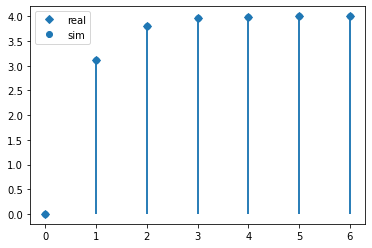

In [21]:
plt.stem(time, y_data, markerfmt='D', label='real', basefmt=' ')
plt.stem(time, y_sim, label='sim', basefmt=' ')
plt.legend()
plt.show()

In [22]:
error = pd.Series(error.flatten())
error.mean()

-1.2582527612418441e-15

In [23]:
error.autocorr(lag=2)

0.6327060997963051

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

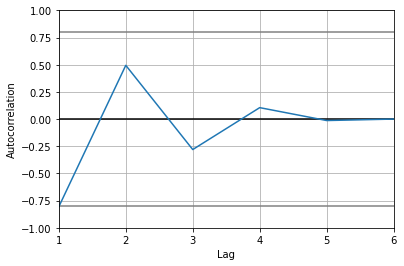

In [24]:
pd.plotting.autocorrelation_plot(error)